# Processing big Sentinel-1 SAR data in python using snappy

- You learn how to use snappy to apply standard pre-processing chain and produce Sentinel-1 analysis ready data.

    1) Download and install latest SNAP release on Windows,
    2) Configure snappy during and after the SNAP installation process,
    3) Setup a virtual environment,
    4) Configure optimal settings for snappy,
    5) Process satellite data using snappy

In [1]:
import sys
#sys.path.append('C:\Users\vaak\.snap\auxdata\snaphu-v1.4.2_win64\bin')
sys.path.append('C:\\Users\\vaak\\.snap\\snap-python\snappy')
sys.path.append('C:\\Users\\vaak\\Anaconda3\\envs\\snap\\Lib')
sys.path.append('C:\Program Files\snap\bin')

#  Load Python modules

In [ ]:
#Need to configure Python to use the SNAP-Python (snappy) interface(https://senbox.atlassian.net/wiki/spaces/SNAP/pages/50855941/Configure+Python+to+use+the+SNAP-Python+snappy+interface)
# Read in unzipped Sentinel-1 SLC products (EW and IW modes)
# Parameters to provide: path, outpath, region_code
#Module                               
from IPython.display import Image, HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from snappy import ProductIO
from zipfile import ZipFile
from snappy import HashMap
from os.path import join
from glob import iglob
from snappy import GPF
import pandas as pd
import numpy as np
import subprocess                           #external calls to system
import datetime
import os, gc
import time

# Sentinel-1 processing using snappy


In the excercise who to create and run a standard Sentinel-1 preprocessing chain to generate analysis-ready data.
SNAP processors  are implemented as GPF operators and can be invoked via Windows or Unix commond line using the GPF graph processing tool-GPT, which can be found in the bin directory of SNAP installation.

Sentinel-1  is  a  constellation  of  two  satellites  (1A  and  1B)  operating  in  C-band.  The  constellation reduces  the  repeat  frequency  of  the  satellites  from  12  to  6  days; making  the  data  more  useful  for interferometric  and polarimetric  applications. Interferometric  Wide  swath  (IW)  is  one  of the acquisition modes of Sentinel-1 capturingdata  over the  landsurface.  In  this  mode,  three subswaths (IW1, IW2,and IW3) are imagedusing Terrain Observation with Progressive Scans SAR (TOPSAR) technique with aspatial resolution of 5 x 20 m. The IW products are delivered in formof slices to make the data more manageable in terms of storage and computational effort. Each slice is a stand-alone product and can be processed independently. Each slice covers approximately 250 x 150  km  in  range  and  azimuth direction. The  nomenclature  of  each  subswath is  basedon the  orbit type,i.e. ascending or descending. The subswath close to the near range is IW1, and the subswath in the far range is IW3. Each subswath consists ofnineburstsin the azimuthdirection. The individually focused complex bursts are arrangedin azimuth-time order with the black-filldemarcation between them.Figure 1represents the imaging geometry of a descending pass Sentinel-1 IW product.

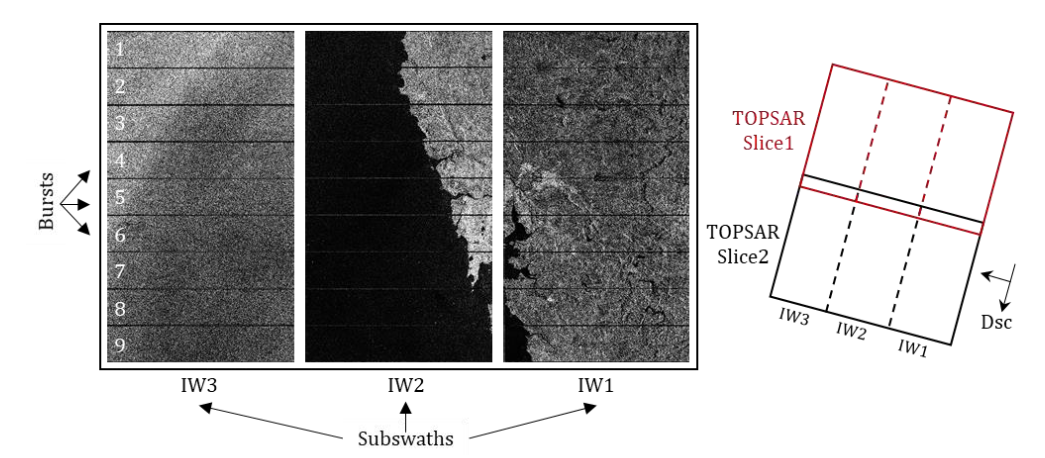

In [3]:
Image('Figs/S1_IWs.png')

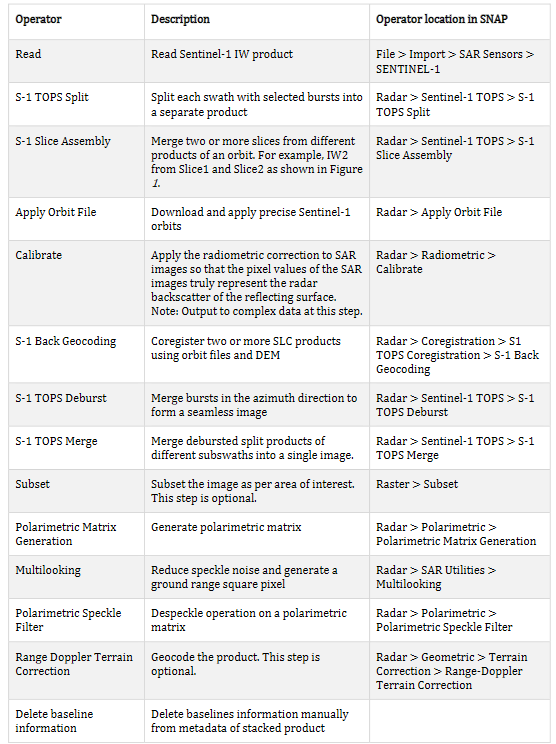

In [6]:
Image('Figs/operators.png')

# Sentinel-1 Product

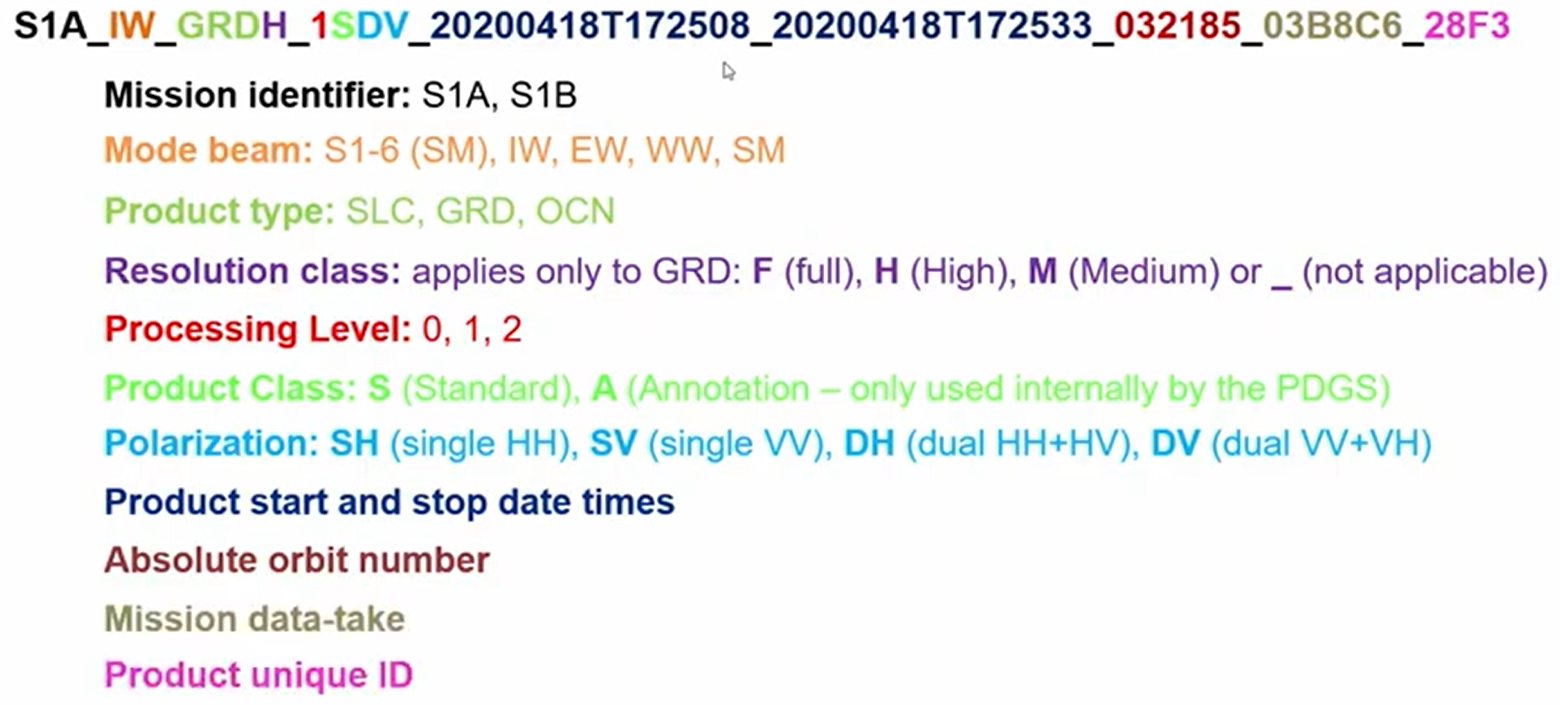

In [110]:
Image('Product_ID.png')

 1. Read product
 2. TOPSAR Split
 3. Apply Orbit File
 4. Thermal Noise Removal
 5. Calibration
 6. Speckle Filtering
 7. TOPSAR Deburst
 8. Terrain Correction
 9. seubset
 10. Write Product
 
 

In [37]:
#call gpt -h from commond line
print(subprocess.Popen(['gpt','-h','Subset'], stdout=subprocess.PIPE,universal_newlines=True).communicate()[0])

# 2. TOPSAR Split

# 3. Apply Orbit File

Orbit state vectors, contained within the metadata information of SAR products, are generally not  accurate.  The  precise  orbits  of  satellites  are  determined  after  several  days  and  are  available  days-to-weeks after the generation of the product. The operation of applying a precise orbit available in SNAP allows the automatic download and update of the orbit state vectors for each SAR scene in its product metadata, providing an accurate satellite position and velocity information.

# 4. Thermal Noise Removal

Sentinel-1   image   intensity   is   disturbed   by   additive   thermal   noise,   particularly   in   the   cross-polarization  channel.  Thermal  noise  removal  reduces  noise  effects  in  the  inter-sub-swath  texture,  in  particular,  normalizing  the  backscatter  signal  within  the  entire  Sentinel-1  scene  and  resulting  in  reduced  discontinuities  between  sub-swaths  for  scenes  in  multi-swath  acquisition  modes.  The  thermal  noise  removal  operator  available  in  SNAP  for  Sentinel-1  data  can  also  re-introduce the noise signal that could have been removed during level-1 product generation, and update  product  annotations  to  allow  for  re-application  of  the  correction.  Sentinel-1  level-1  products provide a noise look-up table (LUT), provided in linear power, for each measurement data set and used to derive calibrated noise profiles matching the calibrated GRD data. 

# 5. Calibration

Calibration is the procedure that converts digital pixel values to radiometrically calibrated SAR backscatter.  The  information  required  to  apply  the  calibration  equation  is  included  within  the  Sentinel-1 GRD product; specifically, a calibration vector included as an annotation in the product allows  simple  conversion  of  image  intensity  values  into  sigma  nought  values.  The  calibration  reverses the scaling factor applied during level-1 product generation, and applies a constant offset and a range-dependent gain, including the absolute calibration constant.

# 6. Speckle filtering


Speckle,  appearing  in  SAR  images  as  granular  noise,  is  due  to  the  interference  of  waves  reflected  from  many  elementary  scatterers.  Speckle  filtering  is  a  procedure  to  increase  image  quality  by  reducing  speckle.  When  such  a  procedure  is  done  at  an  early  processing  stage  of  SAR  data,  speckle  is  not  propagated  in  ongoing  processes  (i.e.,  terrain  correction  or  conversion  to  dB).  Speckle  filtering  is  not  advisable  when  there  is  an  interest  in  the  identification  of  small  spatial  structures or image texture, since it might remove such information. The refined Lee filter has been found  to  be  superior,  with  respect  to  other  single  product  speckle  filters,  for  visual  interpretation,  because of its ability to preserve edges, linear features, and point target and texture information. More  recently,  multitemporal  speckle  filters  have  been  developed  to  reduce  speckle,  taking  advantages  from  multiple  SAR  observations  in  time.  The  proposed  preprocessing  workflow  includes  a  speckle  filtering  step,  which  could  be  skipped  by  selecting  'None'  as  the  filter  type.  Currently, one of the following filters is available in the SNAP single product speckle filter operator: 'Boxcar', 'Median', 'Frost', 'Gamma Map', 'Lee', 'Refined Lee', 'Lee Sigma', 'IDAN'. 

# 7. TOSAR Deburst

to remove demarcation zone between two bursts. 

# 8. Terrain Correction

SAR data are generally sensed with a varying viewing angle greater than 0 degrees, resulting in images  with  some  distortion  related  to  side-looking  geometry.  Terrain  corrections  are  intended  to  compensate for these distortions so that the geometric representation of the image will be as close as possible to the real world. Range Doppler terrain correction is a correction of geometric distortions caused  by  topography,  such  as  foreshortening  and  shadows,  using  a  digital  elevation  model  to  correct the location of each pixel. The range Doppler terrain correction operator available in SNAP 
Proceedings 2019, 18, 11 4  of  4  implements the Range Doppler orthorectification method. for geocoding SAR scenes from images in radar geometry. It makes use of available orbit state vector information in the metadata, the radar timing annotations, and the slant to ground range conversion parameters together with the reference digital elevation model data to derive the precise geolocation information. The target Coordinate Reference System (CRS) can be selected and optionally set to match the UTM zone of the overlaying Sentinel-2  granules.  The  operator  allows  the  selection  of  the  image  resampling  method  and  the  target pixel spacing in the target CRS. This processing step allows the spatial snapping of Sentinel-1 GRD products to Sentinel-2 MSI data grids, in order to geolocate data to a common spatial grid and promote the use of satellite virtual constellations. 

# 9. Conversion to dB

As a last step of the preprocessing workflow, the unitless backscatter coefficient is converted to dB using a logarithmic transformation.

In [6]:
def read(filename):
    output=ProductIO.readProduct(filename)
    return output

def topsar_split(product,IW):
    print('\tApply TOPSAR Split...')
    parameters = HashMap()
    parameters.put('subswath', IW)
    #parameters.put('selectedPolarisations', 'VV')
    output=GPF.createProduct("TOPSAR-Split", parameters, product)
    return output

def do_apply_orbit_file(source):
    print('\tApply orbit file...')
    parameters = HashMap()
    parameters.put('Apply-Orbit-File', True)
    output = GPF.createProduct('Apply-Orbit-File', parameters, source)
    return output

# 
def do_thermal_noise_removal(source):
    print('\tThermal noise removal...')
    parameters = HashMap()
    parameters.put('removeThermalNoise', True)
    output = GPF.createProduct('ThermalNoiseRemoval', parameters, source)
    return output

def do_calibration(source, polarization, pols):
    print('\tCalibration...')
    parameters = HashMap()
    parameters.put('outputSigmaBand', True)
    #if polarization == 'DH':
     #   parameters.put('sourceBands', 'Intensity_HH,Intensity_HV')
    #elif polarization == 'DV':
     #   parameters.put('sourceBands', 'Intensity_VH,Intensity_VV')
    #elif polarization == 'SH' or polarization == 'HH':
     #   parameters.put('sourceBands', 'Intensity_HH')
    #elif polarization == 'SV':
     #   parameters.put('sourceBands', 'Intensity_VV')
    #else:
     #   print("different polarization!")
        
    parameters.put('selectedPolarisations', pols)
    parameters.put('outputImageScaleInDb', False)
    output = GPF.createProduct("Calibration", parameters, source)
    return output

def do_speckle_filtering(source):
    print('\tSpeckle filtering...')
    parameters = HashMap()
    parameters.put('filter', 'Lee')
    parameters.put('filterSizeX', 5)
    parameters.put('filterSizeY', 5)
    output = GPF.createProduct('Speckle-Filter', parameters, source)
    return output

def topsar_deburst(source):  
    parameters = HashMap()
    parameters.put("Polarisations", "VV,VH")
    output=GPF.createProduct("TOPSAR-Deburst", parameters, source)
    return output

def do_terrain_correction(source, proj,GRes, downsample):
    print('\tTerrain correction...')
    parameters = HashMap()
    parameters.put('demName', 'SRTM 3Sec')
    parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
    parameters.put('mapProjection', proj)       # comment this line if no need to convert to UTM/WGS84, default is WGS84
    parameters.put('saveProjectedLocalIncidenceAngle', False)
    parameters.put('saveSelectedSourceBand', True)
    parameters.put('nodataValueAtSea', False)
    parameters.put('pixelSpacingInMeter', GRes)

    while downsample == 1:                      # downsample: 1 -- need downsample to 40m, 0 -- no need to downsample
        parameters.put('pixelSpacingInMeter', 40.0)
        break
    output = GPF.createProduct('Terrain-Correction', parameters, source)
    return output

def do_subset(source, wkt):
    print('\tSubsetting...')
    parameters = HashMap()
    parameters.put('geoRegion', wkt)
    #parameters.put('outputImageScaleInDb', True)
    output = GPF.createProduct('Subset', parameters, source)
    return output

def convert_dB(source):
    print('\converting to db…')
    parameters = HashMap()
    output = GPF.createProduct('LinearToFromdB', parameters, source)
    return output


In [135]:
product_path=r'C:\Users\vaak\Desktop\UoS\weedwatch project\S1_Vembanad\DSC'
input_S1_files=sorted(list(iglob(join(product_path,'**','S1*'),recursive='True')))
name,sensing_mode,product_type, polarization, height, width, band_names=([] for i in range(7))

for i in input_S1_files:
    sensing_mode.append(i.split("_")[3])
    product_type.append(i.split("_")[2])
    polarization.append(i.split("_")[-6])
    S1_read = ProductIO.readProduct(i)
    name.append(S1_read.getName())
    height.append(S1_read.getSceneRasterHeight())
    width.append(S1_read.getSceneRasterWidth())
    band_names.append(S1_read.getBandNames())
    
df_S1_read=pd.DataFrame({'Name':name, 'Sensing Mode': sensing_mode, 'Product type': product_type, 'Polarization':polarization, 'Height':height, 'Width':width, 'Band Names':band_names })



In [112]:
df_S1_read


,Name,Sensing Mode,Product type,Polarization,Height,Width,Band Names
0,S1A_IW_SLC__1SDV_20190124T004042_20190124T0041...,SLC,IW,1SDV,15090,71772,"[i_IW1_VH, q_IW1_VH, Intensity_IW1_VH, i_IW1_V..."
1,S1A_IW_SLC__1SDV_20200119T004047_20200119T0041...,SLC,IW,1SDV,13599,70168,"[i_IW1_VH, q_IW1_VH, Intensity_IW1_VH, i_IW1_V..."
2,S1A_IW_SLC__1SDV_20200119T004112_20200119T0041...,SLC,IW,1SDV,15110,70167,"[i_IW1_VH, q_IW1_VH, Intensity_IW1_VH, i_IW1_V..."
3,S1B_IW_SLC__1SDV_20190223T004009_20190223T0040...,SLC,IW,1SDV,18108,69288,"[i_IW1_VH, q_IW1_VH, Intensity_IW1_VH, i_IW1_V..."


## Multi-date data processing

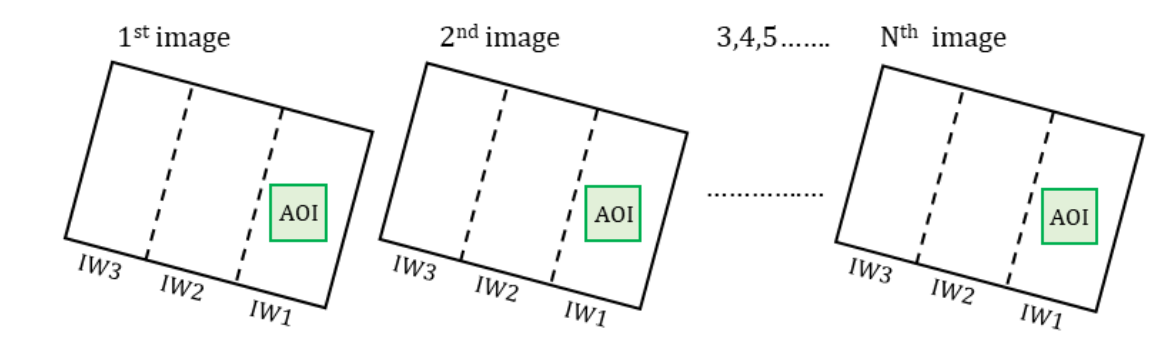

In [5]:
Image('Figs/multidate_processing.png')

In [4]:
def main():
    ## All Sentinel-1 data sub folders are located within a super folder (make sure the data is already unzipped and each sub folder name ends with '.SAFE'):
    path=r'C:\Users\vaak\Desktop\UoS\weedwatch project\S1_Vembanad\DSC'
    outpath = r'C:\Users\vaak\Desktop\UoS\weedwatch project\S1_Vembanad\sigma0'
    if not os.path.exists(outpath):
        os.makedirs(outpath)
        
    LONMIN=str(76.3382)
    LATMIN=str(9.489021)
    LONMAX=str(76.43433)
    LATMAX=str(9.687060)
    IW='IW2'
    GRes=10
    
    #LONMIN=str(78.2584)
    #LATMIN=str(17.5185)
    #LONMAX=str(78.2680)
    #LATMAX=str(17.5296)
    
   # 'POLYGON((78.2584 17.5296,78.2584 17.5185,78.2632 17.5169,78.2680 17.5185,78.2684 17.5224,78.2636 17.5294,78.2584 17.5296))'
  
    wkt='POLYGON (('+LONMIN+' '+LATMIN+','+LONMAX+' '+LATMIN+','+LONMAX+' '+LATMAX+','+LONMIN+' '+LATMAX+','+LONMIN+' '+LATMIN+'))'

    #wkt = 'POLYGON ((76.3834 9.6730149691062, 76.41729354858398 9.6730149691062, \
    #76.41729354858398 9.628506952098645, 76.3834 9.628506952098645, 76.3834 9.6730149691062))'
        
    ## UTM projection parameters
    proj = '''PROJCS["WGS 84 / Auto UTM",GEOGCS["World Geodetic System 1984",
    DATUM["World Geodetic System 1984",SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]],
    AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]],UNIT["degree", 0.017453292519943295],
    AXIS["Geodetic longitude", EAST],AXIS["Geodetic latitude", NORTH]],PROJECTION["Transverse_Mercator"],
    PARAMETER["central_meridian", 75.0],PARAMETER["latitude_of_origin", 0.0],
    PARAMETER["scale_factor", 0.9996],PARAMETER["false_easting", 500000.0],
    PARAMETER["false_northing", 0.0],UNIT["m", 1.0],AXIS["Easting", EAST],AXIS["Northing", NORTH]]'''
    

    
    

    for folder in os.listdir(path):
        gc.enable()
        gc.collect()
        sentinel_1 = ProductIO.readProduct(path + "\\" + folder)
        print(sentinel_1)

        loopstarttime=str(datetime.datetime.now())
        print('Start time:', loopstarttime)
        start_time = time.time()

        ## Extract mode, product type, and polarizations from filename
        
        modestamp = folder.split("_")[1]
        productstamp = folder.split("_")[2]
        polstamp = folder.split("_")[4]

        polarization = polstamp[2:4]

        if polarization == 'DV':
            pols = 'VH,VV'
        elif polarization == 'DH':
            pols = 'HH,HV'
        elif polarization == 'SH' or polarization == 'HH':
            pols = 'HH'
        elif polarization == 'SV':
            pols = 'VV'
        else:
            print("Polarization error!")

        print(pols)    
        ## Start preprocessing:
        topsarsplit=topsar_split(sentinel_1,IW)
        applyorbit = do_apply_orbit_file(topsarsplit)
        thermaremoved = do_thermal_noise_removal(applyorbit)
        calibrated = do_calibration(thermaremoved, polarization, pols)
        topsardeburst=topsar_deburst(calibrated)
        filtered = do_speckle_filtering(topsardeburst)
        del topsarsplit
        del applyorbit
        del thermaremoved
        del calibrated
        del topsardeburst
        ## IW images are downsampled from 10m to 40m (the same resolution as EW images).
        tercorrected = do_terrain_correction(filtered, proj, 0)
        subset = do_subset(tercorrected, wkt)
        res_db=convert_dB(subset)
        del filtered
        del tercorrected

        print("Writing...")
        outputname='sigma0_'+folder[17:25]+'_'+IW

        ProductIO.writeProduct(res_db, outpath + '\\' + outputname, 'GeoTIFF')
        #ProductIO.writeProduct(res_db, outpath + '\\' + folder[:-5], 'GeoTIFF')
        del subset
    

        print('Done.')
        sentinel_1.dispose()
        sentinel_1.closeIO()
        print("--- %s seconds ---" % (time.time() - start_time))

if __name__== "__main__":
    main()

org.esa.snap.core.datamodel.Product[name=S1A_IW_SLC__1SDV_20190124T004042_20190124T004110_025612_02D7DC_531F]
Start time: 2021-02-10 15:53:23.234911
VH,VV
	Apply TOPSAR Split...
	Apply orbit file...
	Thermal noise removal...
	Calibration...
	Speckle filtering...
	Terrain correction...
	Subsetting...
\converting to db…
Writing...
Done.
--- 63.65411996841431 seconds ---
org.esa.snap.core.datamodel.Product[name=S1A_IW_SLC__1SDV_20200119T004047_20200119T004114_030862_038AA2_B3C2]
Start time: 2021-02-10 15:54:27.850206
VH,VV
	Apply TOPSAR Split...
	Apply orbit file...
	Thermal noise removal...
	Calibration...
	Speckle filtering...
	Terrain correction...
	Subsetting...
\converting to db…
Writing...
Done.
--- 45.60952949523926 seconds ---
org.esa.snap.core.datamodel.Product[name=S1A_IW_SLC__1SDV_20200119T004112_20200119T004142_030862_038AA2_266F]
Start time: 2021-02-10 15:55:14.160934
VH,VV
	Apply TOPSAR Split...
	Apply orbit file...
	Thermal noise removal...
	Calibration...
	Speckle filterin

## Covariance Matrix Generation C2

In [3]:
def read(filename):
    output=ProductIO.readProduct(filename)
    return output

def topsar_split(product,IW):
    print('\tApply TOPSAR Split...')
    parameters = HashMap()
    parameters.put('subswath', IW)
    #parameters.put('selectedPolarisations', 'VV')
    output=GPF.createProduct("TOPSAR-Split", parameters, product)
    return output

def do_apply_orbit_file(source):
    print('\tApply orbit file...')
    parameters = HashMap()
    parameters.put('Apply-Orbit-File', True)
    output = GPF.createProduct('Apply-Orbit-File', parameters, source)
    return output

def do_thermal_noise_removal(source):
    print('\tThermal noise removal...')
    parameters = HashMap()
    parameters.put('removeThermalNoise', True)
    output = GPF.createProduct('ThermalNoiseRemoval', parameters, source)
    return output

def do_calibration(source, polarization, pols):
    print('\tCalibration...')
    parameters = HashMap()
    parameters.put('outputSigmaBand', True)
    parameters.put('outputImageInComplex', True)

    #if polarization == 'DH':
     #   parameters.put('sourceBands', 'Intensity_HH,Intensity_HV')
    #elif polarization == 'DV':
     #   parameters.put('sourceBands', 'Intensity_VH,Intensity_VV')
    #elif polarization == 'SH' or polarization == 'HH':
     #   parameters.put('sourceBands', 'Intensity_HH')
    #elif polarization == 'SV':
     #   parameters.put('sourceBands', 'Intensity_VV')
    #else:
     #   print("different polarization!")
    #parameters.put('selectedPolarisations', pols)
    #parameters.put('outputImageScaleInDb', False)
    output = GPF.createProduct("Calibration", parameters, source)
    return output

def do_speckle_filtering(source):
    print('\tSpeckle filtering...')
    parameters = HashMap()
    parameters.put('filter', 'Lee')
    parameters.put('filterSizeX', 5)
    parameters.put('filterSizeY', 5)
    output = GPF.createProduct('Speckle-Filter', parameters, source)
    return output

def topsar_deburst(source):  
    parameters = HashMap()
    parameters.put("Polarisations", "VV,VH")
    output=GPF.createProduct("TOPSAR-Deburst", parameters, source)
    return output

def do_terrain_correction(source, proj, downsample):
    print('\tTerrain correction...')
    parameters = HashMap()
    parameters.put('demName', 'SRTM 3Sec')
    parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
    parameters.put('mapProjection', proj)       # comment this line if no need to convert to UTM/WGS84, default is WGS84
    parameters.put('saveProjectedLocalIncidenceAngle', False)
    parameters.put('saveSelectedSourceBand', True)
    parameters.put('nodataValueAtSea', False)
    parameters.put('pixelSpacingInMeter', 10.0)

    while downsample == 1:                      # downsample: 1 -- need downsample to 40m, 0 -- no need to downsample
        parameters.put('pixelSpacingInMeter', 40.0)
        break
    output = GPF.createProduct('Terrain-Correction', parameters, source)
    return output

def do_subset(source, wkt):
    print('\tSubsetting...')
    parameters = HashMap()
    parameters.put('geoRegion', wkt)
    #parameters.put('outputImageScaleInDb', True)
    output = GPF.createProduct('Subset', parameters, source)
    return output

def convert_dB(source):
    print('\converting to db…')
    parameters = HashMap()
    output = GPF.createProduct('LinearToFromdB', parameters, source)
    return output

def polarimetric_mat(source):
    print('\converting to db…')
    parameters = HashMap()
    parameters.put('matrix', 'C2')
    output = GPF.createProduct('Polarimetric-Matrices', parameters, source)
    return output

def multilook(source,rg,az):
        print('\multilooking…')
        parameters      = HashMap() 
        parameters.put("grSquarePixel", True)
        parameters.put("outputIntensity", False)
        parameters.put("nRgLooks", rg)
        parameters.put("nAzLooks", az)
        output     =  GPF.createProduct("Multilook", parameters, source)
        return output


In [4]:
def main():
    ## All Sentinel-1 data sub folders are located within a super folder (make sure the data is already unzipped and each sub folder name ends with '.SAFE'):
    #path = r'S:\Prosjekter\Landsskog\Vahid\India\DSC'
    path=r'C:\Users\vaak\Desktop\UoS\weedwatch project\S1_Vembanad\DSC'
    outpath = r'C:\Users\vaak\Desktop\UoS\weedwatch project\S1_Vembanad\geoMLC'
    if not os.path.exists(outpath):
        os.makedirs(outpath)
        
    LONMIN=str(76.3382)
    LATMIN=str(9.489021)
    LONMAX=str(76.43433)
    LATMAX=str(9.687060)
    IW='IW2'
    
    
    wkt='POLYGON (('+LONMIN+' '+LATMIN+','+LONMAX+' '+LATMIN+','+LONMAX+' '+LATMAX+','+LONMIN+' '+LATMAX+','+LONMIN+' '+LATMIN+'))'

        
    ## UTM projection parameters
    proj = '''PROJCS["WGS 84 / Auto UTM",GEOGCS["World Geodetic System 1984",
    DATUM["World Geodetic System 1984",SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]],
    AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]],UNIT["degree", 0.017453292519943295],
    AXIS["Geodetic longitude", EAST],AXIS["Geodetic latitude", NORTH]],PROJECTION["Transverse_Mercator"],
    PARAMETER["central_meridian", 75.0],PARAMETER["latitude_of_origin", 0.0],
    PARAMETER["scale_factor", 0.9996],PARAMETER["false_easting", 500000.0],
    PARAMETER["false_northing", 0.0],UNIT["m", 1.0],AXIS["Easting", EAST],AXIS["Northing", NORTH]]'''
    

    
    

    for folder in os.listdir(path):
        gc.enable()
        gc.collect()
        sentinel_1 = ProductIO.readProduct(path + "\\" + folder)
        print(sentinel_1)

        loopstarttime=str(datetime.datetime.now())
        print('Start time:', loopstarttime)
        start_time = time.time()

        ## Extract mode, product type, and polarizations from filename
        modestamp = folder.split("_")[1]
        productstamp = folder.split("_")[2]
        polstamp = folder.split("_")[4]

        polarization = polstamp[2:4]

        if polarization == 'DV':
            pols = 'VH,VV'
        elif polarization == 'DH':
            pols = 'HH,HV'
        elif polarization == 'SH' or polarization == 'HH':
            pols = 'HH'
        elif polarization == 'SV':
            pols = 'VV'
        else:
            print("Polarization error!")

        print(pols)    
        ## Start preprocessing:
        topsarsplit=topsar_split(sentinel_1,IW)
        applyorbit = do_apply_orbit_file(topsarsplit)
        #thermaremoved = do_thermal_noise_removal(applyorbit)
        calibrated = do_calibration(applyorbit, polarization, pols)
        topsardeburst=topsar_deburst(calibrated)
        polmat=polarimetric_mat(topsardeburst)
        rg=4
        az=1
        multilooked=multilook(polmat,rg,az)
            
        del topsarsplit
        del applyorbit
        #del thermaremoved
        del calibrated
        del topsardeburst
        del polmat
        
        ## IW images are downsampled from 10m to 40m (the same resolution as EW images).
        tercorrected = do_terrain_correction(multilooked, proj, 0)
        subset = do_subset(tercorrected, wkt)
        res_db=convert_dB(subset)
        del multilooked
        del tercorrected

        print("Writing...")
        outputname='GeoMLC_'+folder[17:25]+'_'+IW

        ProductIO.writeProduct(res_db, outpath + '\\' + outputname, 'GeoTIFF')
        #ProductIO.writeProduct(res_db, outpath + '\\' + folder[:-5], 'GeoTIFF')
        del subset
    

        print('Done.')
        sentinel_1.dispose()
        sentinel_1.closeIO()
        print("--- %s seconds ---" % (time.time() - start_time))

if __name__== "__main__":
    main()

org.esa.snap.core.datamodel.Product[name=S1A_IW_SLC__1SDV_20190124T004042_20190124T004110_025612_02D7DC_531F]
Start time: 2021-02-09 20:49:36.226287
VH,VV
	Apply TOPSAR Split...
	Apply orbit file...
	Calibration...
\converting to db…
\multilooking…
	Terrain correction...
	Subsetting...
\converting to db…
Writing...
Done.
--- 79.11167645454407 seconds ---
org.esa.snap.core.datamodel.Product[name=S1A_IW_SLC__1SDV_20200119T004047_20200119T004114_030862_038AA2_B3C2]
Start time: 2021-02-09 20:50:57.091616
VH,VV
	Apply TOPSAR Split...
	Apply orbit file...
	Calibration...
\converting to db…
\multilooking…
	Terrain correction...
	Subsetting...
\converting to db…
Writing...
Done.
--- 95.03329873085022 seconds ---


## Exercise

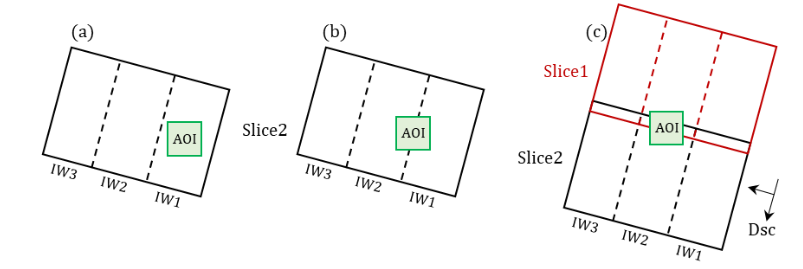

In [7]:
Image('Figs/challenges.png')

1. Multi subswath processing
2. Slice assembly
3. repeat pass coherence generation for sequence of images
